# Transit Optimization Recovery Integrated into `lightkurve`

I'm going to do this using `batman`, but I hope it doesn't get screwed up because I'm not using `ktransit`. It should be fine but you never know

**TODO: add support for multiple planets**

Also - fix `__repr__` method for SyntheticLightCurve.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
from lightkurve.lightcurve import SyntheticLightCurve
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import TransitModel
import lightkurve.injection as inj
import scipy.optimize as op
import batman

Download a TPF of a G-type star from Kepler:

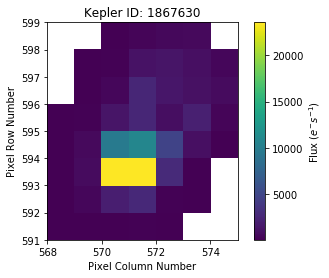

In [3]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
tpf_star.plot()

I'm removing nans and outliers and plotting the lightcurve.

Text(0.5,0,'Time (days)')

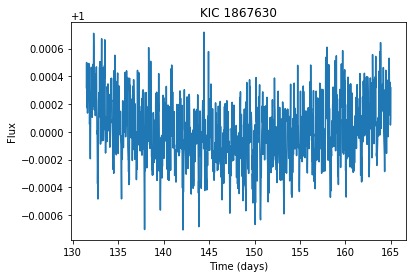

In [4]:
#Remove nans and outliers
lc_star = lc_star.remove_nans().remove_outliers()

lc_star = lc_star.normalize()
plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm creating a lightcurve with `batman` of a Jupiter-sized planet with an orbital period of 5 days:

In [5]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 133                      #time of inferior conjunction
params.per = 3.                       #orbital period
params.rp = 0.15                     #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  

Just the model:

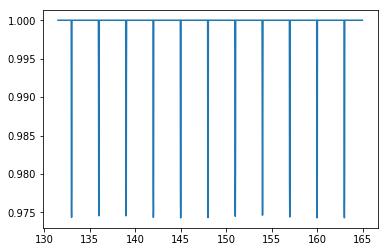

In [6]:
plt.plot(t, flux)

In [7]:
lcinj_time = lc_star.time
lcinj_flux = lc_star.flux * flux
lcinj_fluxerr = lc_star.flux_err

And now the injected transits:

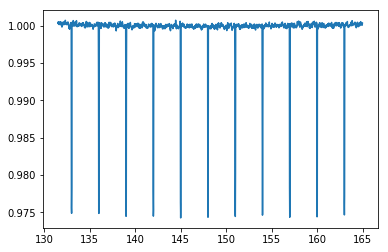

In [8]:
plt.plot(lcinj_time, lcinj_flux)

I'm going to make this a SyntheticLightCurve object, so we can pass it into the `.recover` method.

In [42]:
lcinj = SyntheticLightCurve(time=lcinj_time, flux=lcinj_flux, flux_err=lcinj_fluxerr)

# Not so good recovery method:

# `inj.recover(lc.time, lc.flux, lc.flux_err)`

Now we use `.recover` to recover the transit.

In [64]:
period_f, rprs_f, T0_f = inj.recover(lcinj.time, lcinj.flux, lcinj.flux_err, 'Planet', initial_guess=[1, 2, 3])

In [65]:
print('Fit period: ' + str(period_f) + " Fit rprs: " + str(rprs_f) + " Fit T0: " + str(T0_f))

Fit period: 3.00001076418 Fit rprs: 0.149372917108 Fit T0: 0.999477451617


Let's create a new model with the fitted parameters:

In [66]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = T0_f                   #time of inferior conjunction
params.per = period_f                      #orbital period
params.rp = rprs_f                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m_fit = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_fit = m.light_curve(params)

And plot the fitted model over the data:

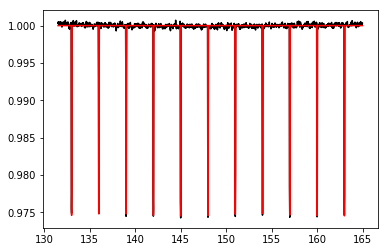

In [67]:
plt.plot(lcinj_time, lcinj_flux, color='k')
plt.plot(t, flux_fit, color='r')

yay

# Preferred recovery method: `lc.recover()`

Now let's test the method in lightkurve.lightcurve.SyntheticLightCurve that points to the inj.recover method.

We can just type lcinj.recover().

In [72]:
period_f, rprs_f, T0_f = lcinj.recover('Planet')

In [73]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = T0_f                   #time of inferior conjunction
params.per = period_f                      #orbital period
params.rp = rprs_f                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m_fit = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_fit = m.light_curve(params)

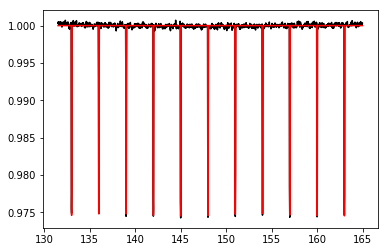

In [74]:
plt.plot(lcinj_time, lcinj_flux, color='k')
plt.plot(t, flux_fit, color='r')

this is much better than the above method

# Work in progress: recovering multiple planets

What if we want to recover more than one planet?

In [54]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 134                   #time of inferior conjunction
params.per = 8                     #orbital period
params.rp = 0.07                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_2 = m.light_curve(params)

In [55]:
flux_mult = lc_star.flux * flux * flux_2

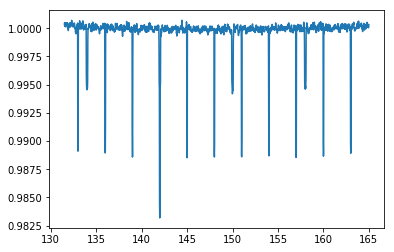

In [56]:
plt.plot(t, flux_mult)

In [59]:
from astropy.stats import BLS

In [60]:
model = BLS(t, flux_mult, dy=0.01)

In [61]:
periodogram = model.autopower(0.2)

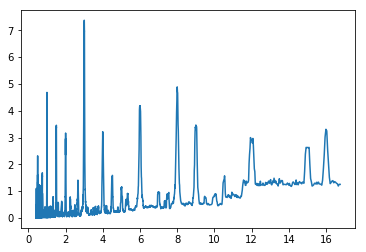

In [62]:
plt.plot(periodogram.period, periodogram.power)

Hmmmm.....